In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant

In [ ]:
data = pd.read_csv('/content/Combined Data.csv')
data.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [ ]:
train, validation = train_test_split(data, shuffle=True, test_size = 0.2, random_state=42)

In [ ]:
train = train.sample(5000)
validation = validation.sample(1000)

In [ ]:
train.head()

,Unnamed: 0,statement,status
12633,12633,I tried hanging myself when I was 16. The rope...,Suicidal
3299,3299,"btw, how are you my ex?",Normal
2923,2923,"To date, 3500 species of cockroaches have been...",Normal
12755,12755,"I cannot sleep, shaking and my mind feels like...",Depression
35740,35740,Suddenly Developed Health Anxiety Greetings Re...,Anxiety


In [ ]:
validation.head()

,Unnamed: 0,statement,status
12422,12422,To start i do not know how to start. I am writ...,Depression
47421,47421,I feel like I’m driving on a highway and I wou...,Depression
19021,19021,"everyone who says it gets better, just keep tr...",Depression
20509,20509,I just got prescribed Prozac for my depression...,Depression
17816,17816,In reading up on the side effects of most anti...,Depression


In [ ]:
train = train.dropna(subset=['statement'])

In [ ]:
train.isnull().sum()

,0
Unnamed: 0,0
statement,0
status,0


In [ ]:
validation = validation.dropna(subset=['statement'])

In [ ]:
validation.isnull().sum()

,0
Unnamed: 0,0
statement,0
status,0


In [ ]:
duplicates = train[train.duplicated(subset=['statement', 'status'], keep=False)]

In [ ]:
train = train.drop_duplicates(subset=['statement', 'status'], keep='first')

In [ ]:
duplicates = validation[validation.duplicated(subset=['statement', 'status'], keep = False)]

In [ ]:
validation = validation.drop_duplicates(subset=['statement', 'status'], keep='first')

In [ ]:
sentiment_counts_train = train['status'].value_counts()
sentiment_counts_validation = validation['status'].value_counts()

In [ ]:
combined_counts = pd.concat([sentiment_counts_train, sentiment_counts_validation], axis = 1)
combined_counts.columns = ['test data', 'validation data']
combined_counts

,test data,validation data
status,,
Normal,1588,331
Depression,1449,266
Suicidal,968,189
Anxiety,357,65
Bipolar,258,70
Stress,228,51
Personality disorder,99,22


Text(0.5, 1.0, 'Sentiments in Validation Data')

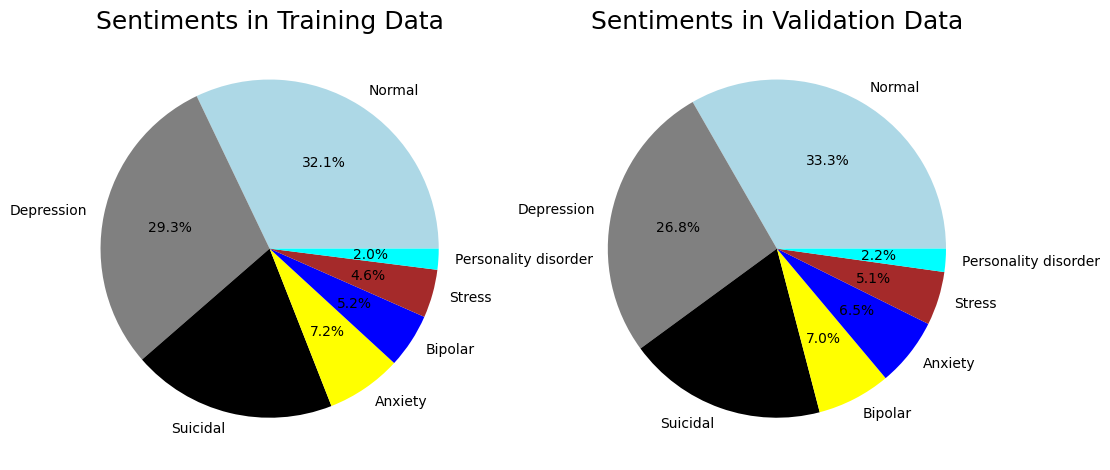

In [ ]:
fig , (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
ax1.pie(sentiment_counts_train, labels = sentiment_counts_train.index, autopct = "%1.1f%%", colors = ['lightblue', 'gray', 'black', 'yellow', 'blue','brown', 'cyan'])
ax1.set_title('Sentiments in Training Data', fontsize = 18)

ax2.pie(sentiment_counts_validation, labels = sentiment_counts_validation.index, autopct="%1.1f%%", colors = ['lightblue', 'gray', 'black', 'yellow', 'blue','brown', 'cyan'])
ax2.set_title('Sentiments in Validation Data', fontsize = 18)

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# For basic Preprocessing
def preprocessing_pipline(text):

    #removing unneccesary data
    text = text.lower()  # Lowercase text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    return text
# To Remove Stopwords
def stopwordsRemoval(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [ ]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
train['statement'].apply(lambda x: preprocessing_pipline(x))
train['statement'].apply(lambda x: stopwordsRemoval(x))
validation['statement'].apply(lambda x: preprocessing_pipline(x))
validation['statement'].apply(lambda x: stopwordsRemoval(x))

,statement
12422,To start know start . I writing get head . As ...
47421,I feel like I ’ driving highway I ’ care I ste...
19021,"everyone says gets better , keep trying please..."
20509,I got prescribed Prozac depression . Any one b...
17816,"In reading side effects anti depressants , see..."
...,...
38326,like people know would get sad commited suicid...
1985,I 'm one n't understand ? ? ? ?
34893,Daily torture This .. Ok I lot sinus . And pos...
52291,intrusive thoughts past mistakes I 'm 23 anxie...


In [ ]:
train.head()

,Unnamed: 0,statement,status
12633,12633,I tried hanging myself when I was 16. The rope...,Suicidal
3299,3299,"btw, how are you my ex?",Normal
2923,2923,"To date, 3500 species of cockroaches have been...",Normal
12755,12755,"I cannot sleep, shaking and my mind feels like...",Depression
35740,35740,Suddenly Developed Health Anxiety Greetings Re...,Anxiety


In [ ]:
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
train['status'].unique()

array(['Suicidal', 'Normal', 'Depression', 'Anxiety', 'Bipolar',
       'Personality disorder', 'Stress'], dtype=object)

In [ ]:
def preprocess_data(df):
    df['label'] = df['status'].map({
        'Depression' : 0,
        'Stress' : 1,
        'Suicidal' : 2,
        'Normal' : 3,
        'Bipolar' : 4,
        'Anxiety' : 5,
        'Personality disorder' : 6,
    })

    return df['statement'].tolist(), df['label'].tolist()

In [ ]:
train_text, train_labels = preprocess_data(train)
test_texts, test_labels = preprocess_data(validation)

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len = 128):
        self.texts = texts
        self.lables = labels
        self.tokenizer = tokenizer
        self.max_len = max_len


    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.lables[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens = True,
            max_length = self.max_len,
            return_token_type_ids = False,
            padding = 'max_length',
            truncation = True,
            return_attention_mask = True,
            return_tensors = 'pt',
        )

        return {
            'input_ids' : encoding['input_ids'].flatten(),
            'attention_mask' : encoding['attention_mask'].flatten(),
            'labels' : torch.tensor(label, dtype = torch.long)
        }



In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = SentimentDataset(train_text, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model_BERT = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 7)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_BERT.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
optimizer = AdamW(model_BERT.parameters(), lr = 2e-5)
num_epochs = 10

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
for epoch in range(num_epochs):
    model_BERT.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model_BERT(input_ids, attention_mask = attention_mask, labels = labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    model_BERT.eval()
    test_preds = []
    test_true = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model_BERT(input_ids, attention_mask = attention_mask, labels = labels)
            preds = torch.argmax(outputs.logits, dim = 1).cpu().numpy()
            test_preds.extend(preds)
            test_true.extend(labels.cpu().numpy())

    accuracy = accuracy_score(test_true, test_preds)
    print(f'Epochs {epoch + 1}/{num_epochs}, Test Accuracy: {accuracy: .4f}')

torch.save(model_BERT.state_dict(), 'sentiment_model_BERT.pth')

Epochs 1/10, Test Accuracy:  0.7726
Epochs 2/10, Test Accuracy:  0.7726
Epochs 3/10, Test Accuracy:  0.7646
Epochs 4/10, Test Accuracy:  0.7706
Epochs 5/10, Test Accuracy:  0.7827
Epochs 6/10, Test Accuracy:  0.7757
Epochs 7/10, Test Accuracy:  0.7686
Epochs 8/10, Test Accuracy:  0.7777
Epochs 9/10, Test Accuracy:  0.7726
Epochs 10/10, Test Accuracy:  0.7817


In [ ]:
print(classification_report(test_true, test_preds, target_names = ['Depression', 'Stress', 'Suicidal', 'Normal','Bipolar', 'Anxiety','Personality disorder']))

                      precision    recall  f1-score   support

          Depression       0.71      0.70      0.70       266
              Stress       0.60      0.55      0.57        51
            Suicidal       0.66      0.69      0.67       189
              Normal       0.94      0.96      0.95       331
             Bipolar       0.79      0.69      0.73        70
             Anxiety       0.85      0.82      0.83        65
Personality disorder       0.57      0.59      0.58        22

            accuracy                           0.78       994
           macro avg       0.73      0.71      0.72       994
        weighted avg       0.78      0.78      0.78       994



In [ ]:
test_true[0]

0

In [ ]:
from sklearn.metrics import confusion_matrix
if not isinstance(test_true[0], str):
  from sklearn.preprocessing import LabelEncoder
  label_encoder = LabelEncoder()
  test_true_encoded = label_encoder.fit_transform(test_true)
  labels = [0, 1, 2, 3, 4, 5, 6]

else:
  test_true_encoded = test_true
  labels = ['Depression', 'Stress', 'Suicidal', 'Normal','Bipolar', 'Anxiety','Personality disorder']

conf_matrix_BERT = confusion_matrix(test_true_encoded, test_preds, labels = labels)
print("Confusion Matrix:")
(conf_matrix_BERT)


Confusion Matrix:


array([[186,   1,  65,   4,   8,   1,   1],
       [  6,  28,   0,   6,   2,   6,   3],
       [ 55,   1, 130,   3,   0,   0,   0],
       [  3,   5,   3, 319,   0,   0,   1],
       [  7,   6,   0,   4,  48,   1,   4],
       [  4,   3,   0,   1,   3,  53,   1],
       [  2,   3,   0,   3,   0,   1,  13]])

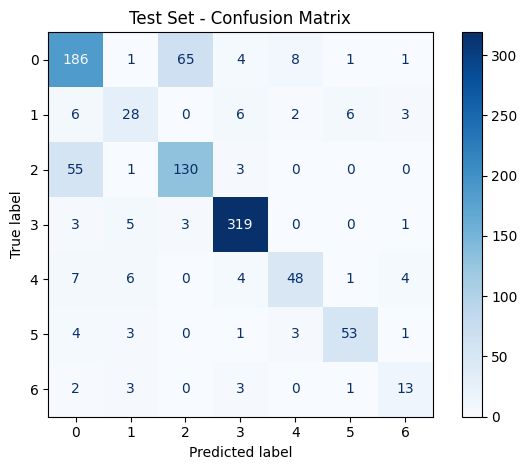

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
test_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix_BERT, display_labels = labels)
test_display.plot(cmap = plt.cm.Blues)
plt.title('Test Set - Confusion Matrix')
plt.grid(False)
plt.tight_layout()
plt.show()